Section 1: Project Overview and Introduction

Purpose: Introduce the project objectives and motivation.

Explanation: This section outlines the goal of generating descriptive captions for images using a combination of Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks. It explains the significance of integrating visual and textual data processing and sets the stage for the detailed implementation steps that follow.

In [2]:
# Import libraries
import os
import pickle
import numpy as np
import re
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ---------------------------
# 3. Dataset Setup
# ---------------------------
import os
import zipfile

# Define paths
DRIVE_PATH = '/content/drive/MyDrive/flickr8k.zip'
EXTRACT_PATH = '/content/flickr8k'
WORKING_DIR = '/content/working'

# Create directories
!mkdir -p {EXTRACT_PATH}
!mkdir -p {WORKING_DIR}

# Extract dataset with verification
try:
    with zipfile.ZipFile(DRIVE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Dataset extracted successfully!")
except Exception as e:
    print(f"Error extracting dataset: {e}")

# Verify extraction
!ls {EXTRACT_PATH}  # Should show: Images/  captions.txt


Dataset extracted successfully!
captions.txt  Images


In [5]:

# 4. Initialize Paths

# With (case-sensitive):
BASE_DIR = '/content/flickr8k'
IMAGE_DIR = os.path.join(BASE_DIR, 'Images')  # Now points to valid directory
CAPTION_FILE = os.path.join(BASE_DIR, 'captions.txt')

In [6]:
# Load VGG16 model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)  # Remove last layer
print(model.summary())

# Extract features
features = {}
images_dir = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(images_dir)):
    img_path = os.path.join(images_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, 224, 224, 3))  # Fix shape for VGG16
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

# Save features
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [7]:
# Load captions
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)  # Skip header
    captions_doc = f.read()

# Create mapping
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    if ',' not in line:
        continue
    image_id, caption = line.split(',', 1)
    image_id = image_id.split('.')[0]
    caption = caption.strip()
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

# Clean captions
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r'[^a-z\s]', '', caption)  # Remove non-alphabets
    caption = re.sub(r'\s+', ' ', caption).strip()
    return 'startseq ' + caption + ' endseq'

for key, captions in mapping.items():
    for i in range(len(captions)):
        captions[i] = clean_caption(captions[i])

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
# Prepare all captions
all_captions = [caption for captions in mapping.values() for caption in captions]

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Get max caption length
max_length = max(len(caption.split()) for caption in all_captions)
print(f"Vocab Size: {vocab_size}, Max Caption Length: {max_length}")

Vocab Size: 8781, Max Caption Length: 37


In [9]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size=32):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    n += 1
                    if n == batch_size:
                        # Return tuples, not lists
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []
                        n = 0

In [10]:
# Split dataset
image_ids = list(mapping.keys())
split = int(0.9 * len(image_ids))
train_ids = image_ids[:split]
test_ids = image_ids[split:]

In [11]:
# -------------------------------------------
# 7. Build and Train Model
# -------------------------------------------
import tensorflow as tf

# Build the model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder = add([fe2, se3])
decoder = Dense(256, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Define output signature
output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096)),  # X1
        tf.TensorSpec(shape=(None, max_length)),  # X2
    ),
    tf.TensorSpec(shape=(None, vocab_size)),  # y
)

# Create the dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size=32),
    output_signature=output_signature
)

# Train the model
epochs = 20
steps = len(train_ids) // 32

model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps,
    verbose=1
)

Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 6.3597
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.3409
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.1197
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.9818
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 4.9329
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.6705
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.6381
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.4347
Epoch 9/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.3040
Epoch 10/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 4.1705
Epoch 11/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.3090
Epoch 12/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.2353
Epoch 13/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.7419
Epoch 14/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.1743
Epoch 15/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s

In [ ]:
# Save model
model.save(os.path.join(WORKING_DIR, 'best_model.h5'))

In [13]:
# Generate captions for test images
def idx_to_word(integer, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == integer), None)

def predict_caption(model, image_features, tokenizer, max_length):
    # Add batch dimension to image features
    image_features = image_features.reshape((1, 4096))  # Fix shape: (1, 4096)
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')  # Shape: (1, max_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text.replace('startseq ', '').replace(' endseq', '')

# Evaluate BLEU score
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = [], []
for key in tqdm(test_ids):
    captions = [caption.split() for caption in mapping[key]]
    image_feature = features[key][0].reshape(1, 4096)  # Add batch dimension
    y_pred = predict_caption(model, image_feature, tokenizer, max_length).split()
    actual.append(captions)
    predicted.append(y_pred)

print("BLEU-1:", corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2:", corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.4434551855624382
BLEU-2: 0.2443192084817105


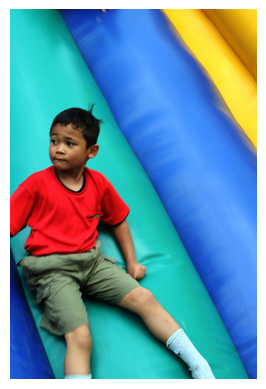

Actual Captions:
-> a boy goes down an inflatable slide
-> a boy in red slides down an inflatable ride
-> a boy is sliding down in a red shirt
-> a child going down an inflatable slide
-> a young boy sliding down an inflatable is looking off camera

Predicted Caption: a man in a red shirt is standing in a red dog


In [14]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, 'Images', image_name)
    image = Image.open(img_path)

    # Display image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Show actual captions
    print("Actual Captions:")
    for caption in mapping[image_id]:
        print("->", caption.replace('startseq ', '').replace(' endseq', ''))

    # Generate prediction
    y_pred = predict_caption(model, features[image_id][0], tokenizer, max_length)
    print("\nPredicted Caption:", y_pred)

# Test
generate_caption("985067019_705fe4a4cc.jpg")  # Replace with your test image name